Вадим_Баташев_176572432

# Import modules

In [ ]:
import pickle
import numpy as np
import pandas as pd
from skimage import io
import os

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path
from time import time
from time import gmtime, strftime
from random import shuffle
import random

import torch
import torch.nn as nn
from torchvision.utils import make_grid
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision import models 
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler, Subset

from matplotlib import colors, pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
# Define function to set seed
def set_seed(seed):
    '''Делает наши результаты воспроизводимыми (вычисления могут немного больше времени занимать)'''
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)


In [ ]:
sns.set_style("dark")

# Unpack data and connect to google drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
# !unzip -q /content/gdrive/MyDrive/simpsons/journey-springfield.zip -d /content/gdrive/MyDrive/simpsons
!unzip -q /content/gdrive/MyDrive/simpsons/journey-springfield.zip

In [ ]:
os.listdir()

['.config',
 'characters_illustration.png',
 'train',
 'testset',
 'sample_submission.csv',
 'gdrive',
 'sample_data']

# Define constants

In [ ]:
RESCALE_SIZE = 224

DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Data folder
MAIN_DIR = Path()

# For PC
# TRAIN_DIR = MAIN_DIR / "data/train/simpsons_dataset"
# TEST_DIR = MAIN_DIR / "data/testset"

# For Colab
TRAIN_DIR = MAIN_DIR / "train/simpsons_dataset"
TEST_DIR = MAIN_DIR / "testset/testset"

if not torch.cuda.is_available():
    print('❌CUDA is not available.  Training on CPU ...')
else:
    print('✔️CUDA is available!  Training on GPU ...')

✔️CUDA is available!  Training on GPU ...


In [ ]:
CLASSES_NAMES = sorted(os.listdir(TRAIN_DIR))
CLASSES_IDXS = np.arange(0, len(CLASSES_NAMES))
N_CLASSES = len(CLASSES_IDXS)
print(N_CLASSES, CLASSES_NAMES)
print(CLASSES_IDXS)

42 ['abraham_grampa_simpson', 'agnes_skinner', 'apu_nahasapeemapetilon', 'barney_gumble', 'bart_simpson', 'carl_carlson', 'charles_montgomery_burns', 'chief_wiggum', 'cletus_spuckler', 'comic_book_guy', 'disco_stu', 'edna_krabappel', 'fat_tony', 'gil', 'groundskeeper_willie', 'homer_simpson', 'kent_brockman', 'krusty_the_clown', 'lenny_leonard', 'lionel_hutz', 'lisa_simpson', 'maggie_simpson', 'marge_simpson', 'martin_prince', 'mayor_quimby', 'milhouse_van_houten', 'miss_hoover', 'moe_szyslak', 'ned_flanders', 'nelson_muntz', 'otto_mann', 'patty_bouvier', 'principal_skinner', 'professor_john_frink', 'rainier_wolfcastle', 'ralph_wiggum', 'selma_bouvier', 'sideshow_bob', 'sideshow_mel', 'snake_jailbird', 'troy_mcclure', 'waylon_smithers']
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41]


# Visualise distributions 

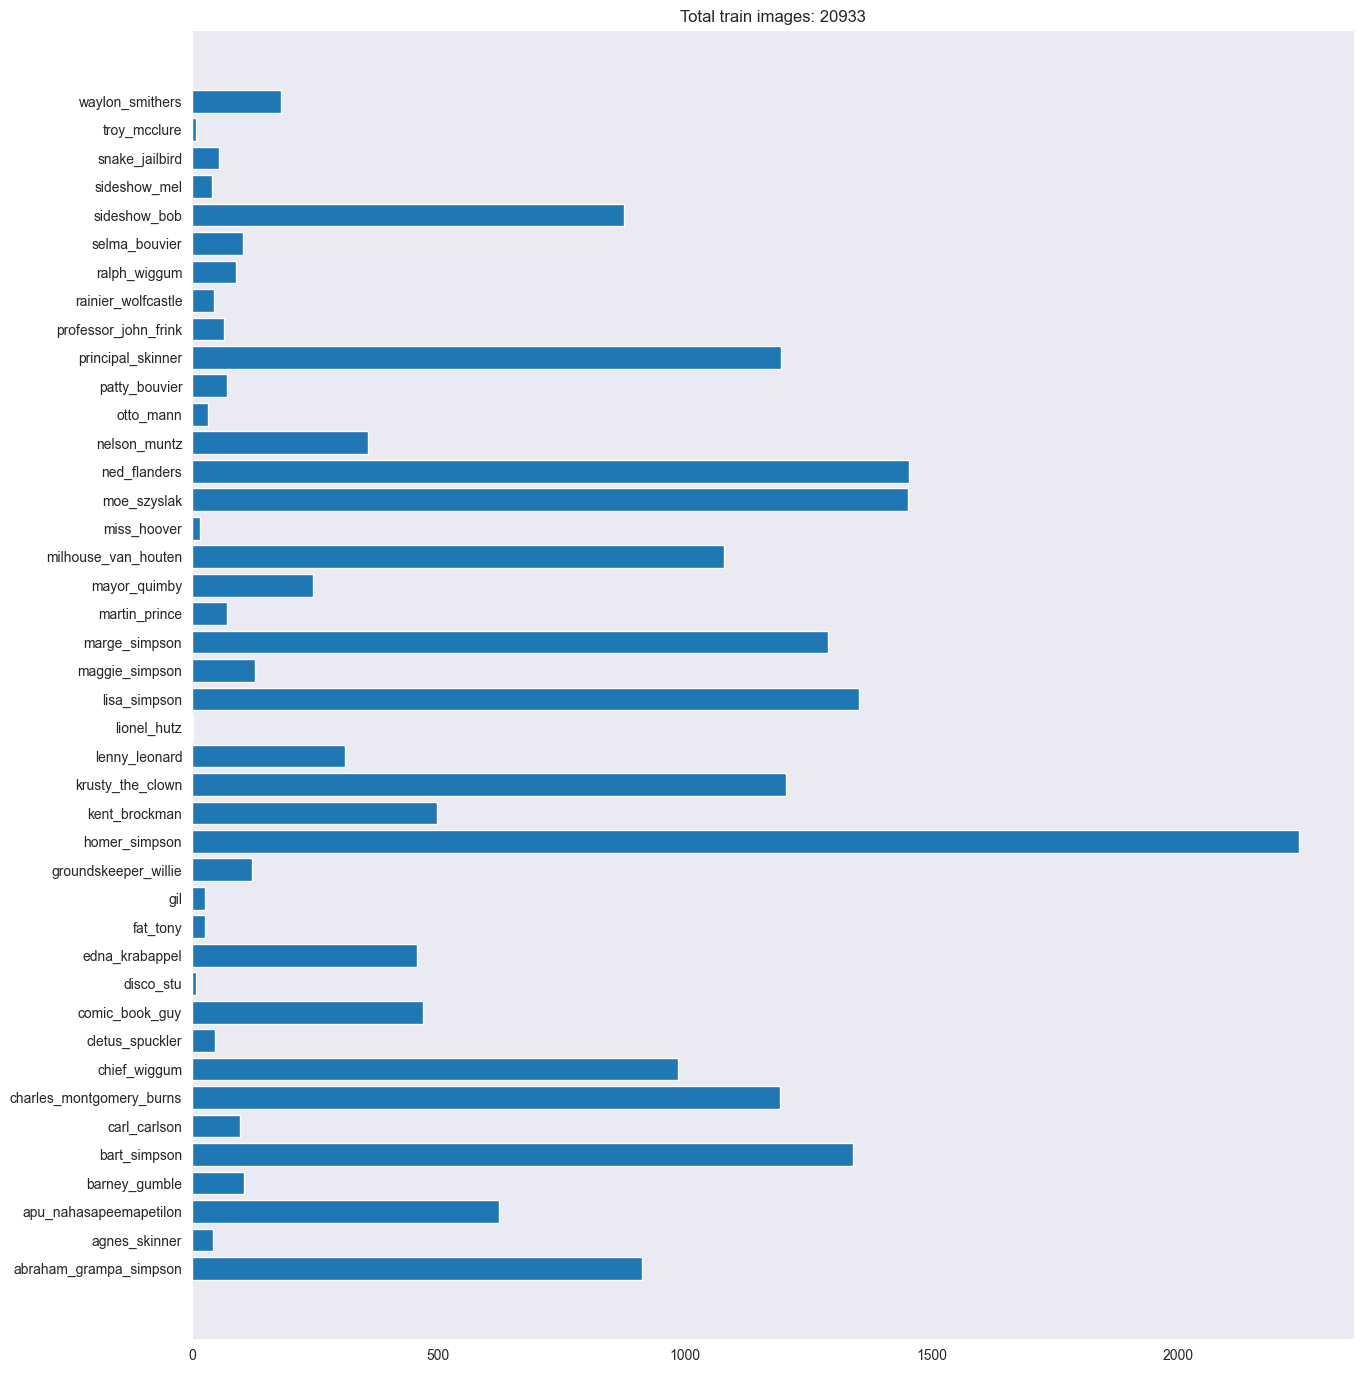

In [ ]:
counter = []

for target in CLASSES_NAMES:
    imgs = os.listdir(TRAIN_DIR / target)
    counter.append(len(imgs))

TOTAL_IMAGES = sum(counter)
plt.figure(figsize=(15, 17))
plt.title(f"Total train images: {TOTAL_IMAGES}")
plt.barh(CLASSES_NAMES, counter)
plt.show()

## Calculate mean and std

In [ ]:
def get_mean_and_std(batch_size):
    training_transforms = transforms.Compose([
        transforms.Resize((RESCALE_SIZE, RESCALE_SIZE)),
        transforms.ToTensor()
        ])
    dataset = ImageFolder(root=TRAIN_DIR, transform=training_transforms)
    loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=False)

    mean = 0.
    std = 0.
    total_images_count = 0
    for images, _ in tqdm(loader):
        image_count_in_a_batch = images.size(0)
        images = images.view(image_count_in_a_batch, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images_count += image_count_in_a_batch
    mean /= total_images_count
    std /= total_images_count

    return mean, std

# mean, std = get_mean_and_std(512)
# mean, std
# (tensor([0.4623, 0.4075, 0.3524]), tensor([0.2125, 0.1913, 0.2212]))

# Create DataLoader

train -> val -> test

## Train and val dataloaders

In [ ]:
class SimpsonsDataSet():
    def __init__(self, *, train_dir, valid_size=0.25, total_images=20933):
        self.train_dir = train_dir
        self.valid_size = valid_size
        self.total_images = total_images

        self.mean = torch.Tensor([0.485, 0.456, 0.406])
        self.std = torch.Tensor([0.229, 0.224, 0.225])

        self.train_transform = transforms.Compose([
            transforms.Resize((RESCALE_SIZE, RESCALE_SIZE)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            # transforms.RandomRotation(90),
            transforms.ToTensor(),
            transforms.Normalize(self.mean, self.std)
            ])
        
        self.test_transform = transforms.Compose([
            transforms.Resize((RESCALE_SIZE, RESCALE_SIZE)),
            transforms.ToTensor(),
            transforms.Normalize(self.mean, self.std)
            ])

        self.train_dataset = ImageFolder(root=self.train_dir,
                                         transform=self.train_transform)

    def get_train_val_loader(self, batch_size):

        valid_images = int(self.valid_size * self.total_images)
    
        total_indexes = list(range(self.total_images))
        shuffle(total_indexes)
        
        train_subset = Subset(self.train_dataset, total_indexes[valid_images:])
        valid_subset = Subset(self.train_dataset, total_indexes[0:valid_images])
        
        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        valid_loader = DataLoader(valid_subset, batch_size=batch_size, shuffle=False)
        
        return train_loader, valid_loader

    def get_test_loader(self, batch_size):
        test_loader = DataLoader(self.test_dataset, batch_size=batch_size, shuffle=False)
        return test_loader

    def show_train_images(self):
        loader = self.get_test_loader(9)
        for x, y in loader:
            grid = make_grid(x, nrow=3)
            print(f"labels: {y}")
            plt.figure(figsize=(11, 11))
            plt.imshow(np.transpose(grid, (1, 2, 0)))
            break


## Test dataloader

In [ ]:
class TestDataset(Dataset):
    def __init__(self, test_dir):
        super().__init__()
        self.test_dir = test_dir
        self.test_images = len(os.listdir(test_dir))
        self.transform = transforms.Compose([
            transforms.Resize((RESCALE_SIZE, RESCALE_SIZE)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        self.files = sorted(list(os.listdir(test_dir)))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, index):
        image = Image.open(TEST_DIR / self.files[index])
        image.load()
        return self.transform(image), self.files[index]

# Create own architecture

In [ ]:
class CNNClassifier(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(8)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(16)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(32)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(64)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=5, padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(96)
        )
        self.conv6 = nn.Sequential(
            nn.Conv2d(in_channels=96, out_channels=128, kernel_size=5, padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(128)
        )
        self.linear = nn.Sequential(
            nn.Linear(128 * 3 * 3, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),

            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),

            nn.Linear(128, n_classes)
        )
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        
        x = x.view(x.size(0), -1)
        logits = self.linear(x)
        return logits

# Create train/valid/test class

In [ ]:
class FitModel():
    def __init__(self, model, optimizer, criterion, scheduler=None, batch_size=32, valid_size=0.25):
        self.model = model.to(DEVICE)

        self.datasets = SimpsonsDataSet(train_dir=TRAIN_DIR, valid_size=valid_size)
        self.train_loader, self.val_loader = self.datasets.get_train_val_loader(batch_size)
        
        self.total_images = 20933
        self.write_loss = 10
        
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler

        self.history = {"train_loss": [],
                        "valid_loss": [],
                        "train_acc": [], 
                        "valid_acc": [],}

    def _train(self, current_epoch):
        loss_sum = 0.
        running_corrects = 0
        images_in_loader = 0
        
        loop = tqdm(enumerate(self.train_loader, start=1),
                    leave=True,
                    total=len(self.train_loader))

        self.model.train()
        for batch_number, (X, y) in loop:

            X = X.to(DEVICE)
            y = y.to(DEVICE)

            self.optimizer.zero_grad()

            output = self.model(X)
            
            loss = self.criterion(output, y)
            loss.backward()
            
            self.optimizer.step()
            
            preds = torch.argmax(output, 1)
            running_corrects += torch.sum(preds == y.data).item()
            loss_sum += loss.item()
            images_in_loader += len(X)

            if batch_number % self.write_loss == 0:
                self.history["train_loss"].append(loss_sum / self.write_loss)
                loss_sum = 0.

            loop.set_description(f"Train epoch: {current_epoch}")
            loop.set_postfix(loss=round(loss.item(), 2))
        self.history["train_loss"].append(loss_sum / (batch_number % self.write_loss))
        self.history["train_acc"].append(running_corrects / images_in_loader)

    
    def _valid(self, current_epoch):
        loss_sum = 0.
        images_in_loader = 0

        loop = tqdm(enumerate(self.val_loader, start=1),
                    leave=True,
                    total=len(self.val_loader))

        with torch.no_grad():
            self.model.eval()
            running_corrects = 0.0
            for batch_number, (X, y) in loop:
                X = X.to(DEVICE)
                y = y.to(DEVICE)

                output = self.model(X)
                loss = self.criterion(output, y)

                loss_sum += loss.item()

                preds = torch.argmax(output, 1)
                running_corrects += torch.sum(preds == y.data).item()
                images_in_loader += len(X)

                if batch_number % self.write_loss == 0:

                    self.history["valid_loss"].append(loss_sum / self.write_loss)
                    loss_sum = 0.

                loop.set_description(f"Valid epoch: {current_epoch}")
                loop.set_postfix(loss=round(loss.item(), 2))
            self.history["valid_loss"].append(loss_sum / (batch_number % self.write_loss))
            self.history["valid_acc"].append(running_corrects / images_in_loader)

    # Train and eval model
    def fit(self, epochs=5):
        for epoch in range(1, epochs + 1):
            self._train(epoch)
            self._valid(epoch)
            if self.scheduler is not None:
                self.scheduler.step()
    
    # Plot loass and accuracy
    def plot(self):
        sns.set_style("darkgrid")
        fig, axes = plt.subplots(2, 2, figsize=(18, 12))

        axes[0, 0].set_title("Train loss")
        axes[0, 0].plot(self.history["train_loss"])

        axes[0, 1].set_title("Valid loss")
        axes[0, 1].plot(self.history["valid_loss"])

        axes[1, 0].set_title("Train acc")
        axes[1, 0].plot(self.history["train_acc"])

        axes[1, 1].set_title("Valid acc")
        axes[1, 1].plot(self.history["valid_acc"])

    # Create submission file
    def submit_pred(self, batch_size):
        test_dataset = TestDataset(TEST_DIR)
        test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

        with torch.no_grad():
            self.model.eval()
            logits = []
            image_names = []

            for X, batch_names in tqdm(test_loader):
                X = X.to(DEVICE)
                
                output = self.model(X).cpu()
                batch_logits = torch.argmax(output, 1)
                
                logits.append(batch_logits)
                image_names.append(np.array(batch_names))
            
            names = np.concatenate(image_names)
            probs = torch.cat(logits).numpy()
            labels = self._get_labels(probs)
            
            submission = pd.DataFrame({"Id": names, "Expected": labels})
            current_time = strftime("%d.%b.%Y %H:%M:%S", gmtime())
            submission.to_csv(f"submissuin_{current_time}.csv", index=False)

    def _get_labels(self, probs):
        labels = []
        for name in probs:
            labels.append(CLASSES_NAMES[name])
        return labels

In [ ]:
def get_weight():
    counter = []
    for target in CLASSES_NAMES:
        imgs = os.listdir(TRAIN_DIR / target)
        counter.append(len(imgs))
    
    counter = torch.Tensor(counter)
    total_images = sum(counter)
    weights = counter / total_images
    
    return weights.to(DEVICE)

# Learning

In [ ]:
BATCH_SIZE = 128
LEARNING_RATE = 0.001
layers_to_unfreeze = 6

set_seed(42)

In [ ]:
model = models.vgg16_bn(weights='IMAGENET1K_V1')

# model

In [ ]:
# Freeze first layers
for param in model.features[:-layers_to_unfreeze].parameters():
    param.requires_grad = False

In [ ]:
# Create classifier
model.classifier = nn.Sequential(
                         nn.Linear(in_features=25088, out_features=4096),
                         nn.ReLU(),
                         nn.Dropout(p=0.5),
                         nn.BatchNorm1d(4096),
                         nn.Linear(in_features=4096, out_features=N_CLASSES),
)
model.classifier.requires_grad = True

total_parameters = len([param.requires_grad for param in model.parameters()])
trainable = sum([param.requires_grad for param in model.parameters()])
print(f"Total layers: {total_parameters}\nTrainable layers: {trainable}")

Total layers: 58
Trainable layers: 12


In [ ]:
criterion = nn.CrossEntropyLoss(weight=get_weight())

optimizer = torch.optim.Adam(list(model.features[:-layers_to_unfreeze].parameters()) + 
                             list(model.classifier.parameters())
                             )

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5, verbose=True)


In [ ]:
cnn_model = FitModel(model, optimizer, criterion, scheduler=scheduler, batch_size=BATCH_SIZE, valid_size=0.2)

In [ ]:
cnn_model.fit(epochs=18)

In [ ]:
cnn_model.optimizer = torch.optim.Adam(list(model.features[:-layers_to_unfreeze].parameters()) + 
                             list(model.classifier.parameters()),
                             lr=LEARNING_RATE
                             )

In [ ]:
cnn_model.submit_pred(32)

100%|██████████| 31/31 [00:10<00:00,  2.86it/s]


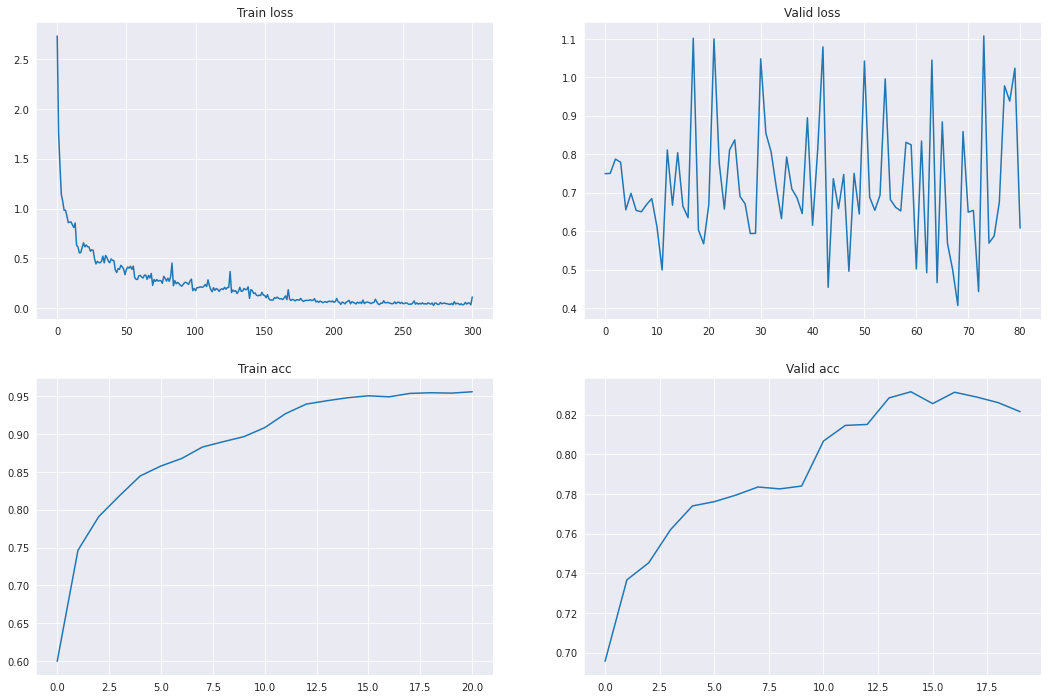

In [ ]:
cnn_model.plot()

In [4]:
from time import time

In [5]:
start_time = time()

In [15]:
time() - start_time

10.112009048461914